In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

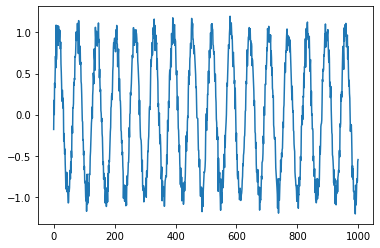

In [ ]:
# Make the original data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1

# Plot it
plt.plot(series)
plt.show()

In [ ]:
### Build the dataset
# Can we use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10) Y.shape (990, 1)


In [ ]:
##' Try autoregressive linear model
model = nn.Linear(T, 1)

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

Can't split up data randomly as real forcasting models need to predict the future, and therefore can't train on points within that future. In this case I will train on the first half and test on the second half (this is not necessary for sine waves as they are periodic, but I feel like it's good practice anyway)

In [ ]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
#Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):
  
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it+1) % 5 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss.item():.4f}')

  return train_losses, test_losses

Let's actually talk about the contents of the training loop so we can explain it. There are several components inside the loop that we need to understand:


*   optimizer.zero_grad() sets the gradients to zero. This is important to do before we start backpropagating, as PyTorch accumulates the gradients on subsequent backward passes (which is convenient while training RNNs). The gradients are summed on every loss.backward() call. 
*   When optimizer is initialised, it is told which tensors of the model it should be updating, and the gradients are stored by the tensors temselves (they have grad and requires_grad attributes) once backward() is called on the loss. This computes the gradients for all tensors in the model.
*   optimizer.step() makes the optimizer iterate over all the parameters (tensors) it is supposed to update and uses their internally stored grad to update their values



In [ ]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/200, Train Loss: 0.0768, Test Loss: 0.0768
Epoch 10/200, Train Loss: 0.0184, Test Loss: 0.0184
Epoch 15/200, Train Loss: 0.0265, Test Loss: 0.0265
Epoch 20/200, Train Loss: 0.0290, Test Loss: 0.0290
Epoch 25/200, Train Loss: 0.0194, Test Loss: 0.0194
Epoch 30/200, Train Loss: 0.0161, Test Loss: 0.0161
Epoch 35/200, Train Loss: 0.0175, Test Loss: 0.0175
Epoch 40/200, Train Loss: 0.0163, Test Loss: 0.0163
Epoch 45/200, Train Loss: 0.0151, Test Loss: 0.0151
Epoch 50/200, Train Loss: 0.0155, Test Loss: 0.0155
Epoch 55/200, Train Loss: 0.0155, Test Loss: 0.0155
Epoch 60/200, Train Loss: 0.0151, Test Loss: 0.0151
Epoch 65/200, Train Loss: 0.0149, Test Loss: 0.0149
Epoch 70/200, Train Loss: 0.0147, Test Loss: 0.0147
Epoch 75/200, Train Loss: 0.0146, Test Loss: 0.0146
Epoch 80/200, Train Loss: 0.0146, Test Loss: 0.0146
Epoch 85/200, Train Loss: 0.0145, Test Loss: 0.0145
Epoch 90/200, Train Loss: 0.0144, Test Loss: 0.0144
Epoch 95/200, Train Loss: 0.0144, Test Loss: 0.0144
Epoch 100/200

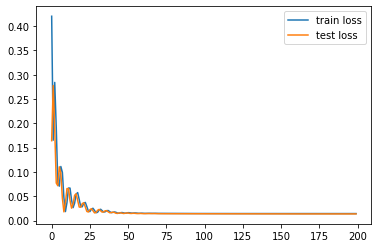

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# "Wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# Index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].view(1, -1)
  p = model(input_)[0, 0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

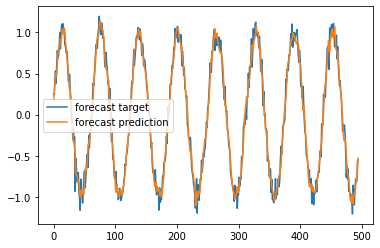

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

The issue with this approach is using the true input data to predict true values of the time series. Define a variable last_x to define the first input vector and take no new values from the actual dataset. 

In [ ]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# Last train input
# 1-D array of length T
last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions) < len(validation_target):
  input_ = last_x.view(1, -1)
  p = model(input_)
  # [0, 0] # 1x1 array -> scalar

  # Update the predictions list
  validation_predictions.append(p[0, 0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

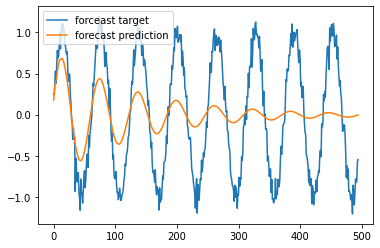

In [ ]:
plt.plot(validation_target, label='forceast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

The above approach creates a sliding window of data, where after each iteration of the loop the first value of x is thrown away, and then the remaining values are concatenated with the new prediction (which keeps the shape of the inputs consistent). 

It may look as if the second approach gives a worse result (the prediction and targets seem to be less aligned), however note that the first approach is not nearly as effective as understanding the true underlying function of the signal behind the noise. The second approach is able to learn that the signal is both smooth and periodic. 